## Analyzing Brazilian E-Commerce Dynamics  

**Objective**: Investigate customer behavior, seller performance, and operational bottlenecks in Olist’s marketplace using real-world transactional data.  

**Dataset**: Includes 100k+ orders, 9 relational tables (customers, sellers, products, reviews, etc.).  

**Methodology**:  
1. **Data Cleaning**: Geolocation validation, payment anomaly detection, null & empty entry analysis.  
2. **EDA**: Customer segmentation, delivery time vs. satisfaction trends.  
3. **Hypothesis Testing**: Pricing bias across regions, seller efficiency impact.  
4. **Advanced Analytics**: PCA for customer behavior patterns.  

**Business Impact**: Recommendations for improving customer retention, delivery logistics, and seller performance.  

In [1]:
# Core Imports
import os
import shutil
import zipfile
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Statistical Analysis
from scipy import stats
from scipy.stats import spearmanr, kruskal

# Machine Learning & Dimensionality Reduction
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Kaggle Dataset Download
import kagglehub

In [2]:
try:
    dataset_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
    print(f'Dataset downloaded to {dataset_path}')

    if zipfile.is_zipfile(dataset_path):
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall('data/')
            print(f'Dataset extracted to data/ directory')
    else:
        print('Downloaded file is not a zip archive.')
except Exception as e:
    print(f'Error downloading dataset: {e}')
    print("Alternative: Download manually from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce")

Dataset downloaded to /home/krmsh1n5/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2
Downloaded file is not a zip archive.


In [3]:
data_files = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "product_category_name": "product_category_name_translation.csv",
}

datasets = {}
try:
    for name, file in data_files.items():
        file_path = os.path.join(dataset_path, file)
        datasets[name] = pd.read_csv(file_path, encoding='latin-1')
        print(f"Loaded {name} dataset: {datasets[name].shape}")
except FileNotFoundError as e:
    print(f'File not found: {e}')
    print("Verify dataset files are in /data directory")

Loaded customers dataset: (99441, 5)
Loaded geolocation dataset: (1000163, 5)
Loaded order_items dataset: (112650, 7)
Loaded order_payments dataset: (103886, 5)
Loaded order_reviews dataset: (99224, 7)
Loaded orders dataset: (99441, 8)
Loaded products dataset: (32951, 9)
Loaded sellers dataset: (3095, 4)
Loaded product_category_name dataset: (71, 2)


## 1. Geolocation Validation  
**Objective**: Identify invalid customer/seller coordinates to ensure data reliability.  
**Method**:  
- Filter latitudes > 5°N or longitudes < -75°W (Brazil’s approximate bounds).  
- Plot valid/invalid coordinates using Plotly’s `scatter_mapbox`.  
**Impact**: Ensures accurate delivery time analysis by removing unrealistic locations. 

In [4]:
BRAZIL_LAT_RANGE = (-33.75, 5.27)  # South to North
BRAZIL_LNG_RANGE = (-73.99, -34.79) # West to East

geo = datasets['geolocation']

geo['is_valid'] = (
    (geo['geolocation_lat'].between(BRAZIL_LAT_RANGE[0], BRAZIL_LAT_RANGE[1])) & 
    (geo['geolocation_lng'].between(BRAZIL_LNG_RANGE[0], BRAZIL_LNG_RANGE[1]))
)

# Split into valid/invalid datasets
valid_geo = geo[geo['is_valid']]
invalid_geo = geo[~geo['is_valid']]

print(f"Valid entries: {len(valid_geo):,} ({len(valid_geo)/len(geo):.1%})")
print(f"Invalid entries: {len(invalid_geo):,} ({len(invalid_geo)/len(geo):.1%})")

Valid entries: 1,000,121 (100.0%)
Invalid entries: 42 (0.0%)


In [5]:
valid_sample = valid_geo.sample(frac=0.1, random_state=42)
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=invalid_geo['geolocation_lat'],
    lon=invalid_geo['geolocation_lng'],
    mode='markers',
    marker=dict(size=6, color='red', opacity=0.7), 
    name=f'Invalid Locations ({len(invalid_geo):,})'
))


fig.add_trace(go.Scattermapbox(
    lat=valid_sample['geolocation_lat'],
    lon=valid_sample['geolocation_lng'],
    mode='markers',
    marker=dict(size=4, color='blue', opacity=0.3),
    name=f'Valid Locations (10% sample)'
))

fig.update_layout(
    title=f'Geolocation Validation<br><sup>Showing 10% valid vs full {len(invalid_geo):,} invalid</sup>',
    mapbox=dict(
        style="carto-positron",
        zoom=1.5,
        center=dict(lat=-14.2350, lon=-51.9253)
    ),
    height=700,
    width=900,
    showlegend=True
)


fig.show(renderer="plotly_mimetype")

In [6]:
clean_geo = geo[geo['is_valid']].drop(columns=['is_valid'])
clean_geo.to_csv('cleaned_geolocation.csv', index=False)

In [7]:
source_file = 'cleaned_geolocation.csv'
destination_folder = 'cleaned_data'

os.makedirs(destination_folder, exist_ok=True)

destination_file = os.path.join(destination_folder, source_file)

try:
    # Move the file to the destination folder
    shutil.move(source_file, destination_file)
    print(f"File '{source_file}' has been moved to '{destination_folder}' successfully.")
except FileNotFoundError:
    print(f"Error: The file '{source_file}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

File 'cleaned_geolocation.csv' has been moved to 'cleaned_data' successfully.


## 2. Payment Value Anomalies  
**Objective**: Detect pricing errors or discounts not reflected in `payment_value`.  
**Method**:  
- Flag orders where `abs(payment_value - (price + freight_value)) > 0.1 * (price + freight_value)`.  
- Analyze anomalies by product category (e.g., electronics vs. furniture).  
**Impact**: Highlights potential fraud or data entry issues affecting revenue reporting. 

In [8]:
order_items = datasets['order_items']
payments = datasets['order_payments']
products = datasets['products'][['product_id', 'product_category_name']]

In [9]:
order_totals = order_items.groupby('order_id').agg(
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum')
).reset_index()

payment_totals = payments.groupby('order_id')['payment_value'].sum().reset_index()

merged_data = pd.merge(order_totals, payment_totals, on='order_id')

merged_data = pd.merge(merged_data, 
                       order_items[['order_id', 'product_id']].drop_duplicates(),
                       on='order_id')

merged_data = pd.merge(merged_data, products, on='product_id')

In [10]:
merged_data['expected_total'] = merged_data['total_price'] + merged_data['total_freight']
merged_data['difference'] = merged_data['payment_value'] - merged_data['expected_total']
merged_data['abs_difference'] = abs(merged_data['difference'])
merged_data['threshold'] = 0.1 * merged_data['expected_total']

merged_data['is_anomaly'] = merged_data['abs_difference'] > merged_data['threshold']

anomalies = merged_data[merged_data['is_anomaly']]

print(f"Total orders: {len(merged_data):,}")
print(f"Anomalous orders: {len(anomalies):,} ({len(anomalies)/len(merged_data):.1%})")

Total orders: 102,424
Anomalous orders: 139 (0.1%)


In [11]:
category_analysis = anomalies.groupby('product_category_name').agg(
    anomaly_count=('order_id', 'nunique'),
    avg_difference=('difference', 'mean')
).sort_values('anomaly_count', ascending=False).reset_index()

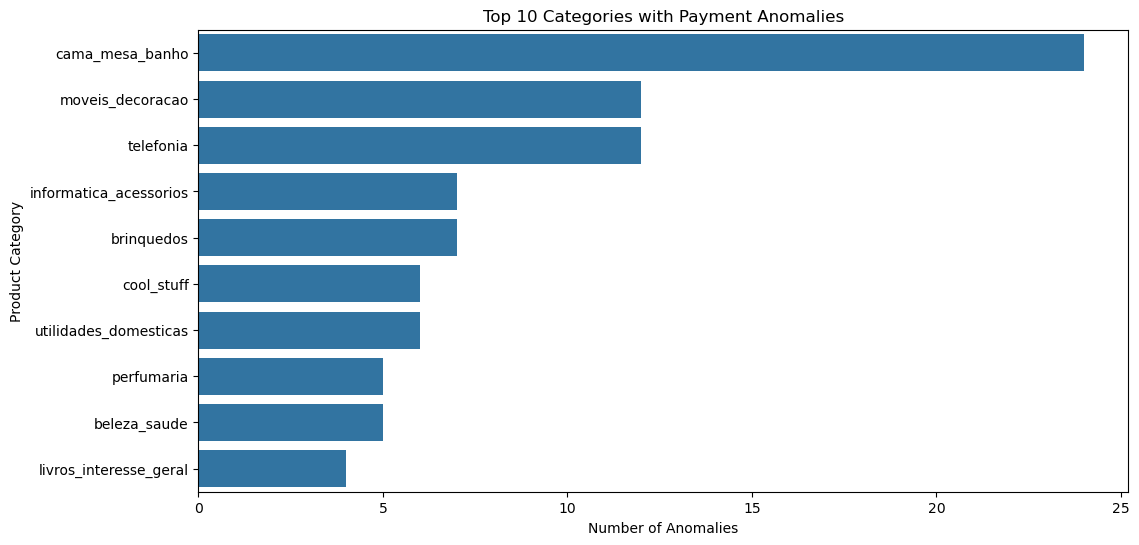


Sample Anomalies:


order_id product_category_name  expected_total  \
96057  eff853aac91ab73f53304207c4571d1f             telefonia           36.09   
47583  77411858d5ea9f0dec6b071cec64349f             telefonia           28.22   
21059  34e6b9f685df8e8b6465a715689c749f            brinquedos          122.57   

       payment_value  difference  
96057          40.78        4.69  
47583          31.89        3.67  
21059         135.34       12.77

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(data=category_analysis.head(10), 
            x='anomaly_count', 
            y='product_category_name', 
            )
plt.title('Top 10 Categories with Payment Anomalies')
plt.xlabel('Number of Anomalies')
plt.ylabel('Product Category')
plt.show()

sample_anomalies = anomalies.sample(3, random_state=42)[[
    'order_id', 'product_category_name', 
    'expected_total', 'payment_value', 'difference'
]]
print("\nSample Anomalies:")
display(sample_anomalies)

In [18]:
anomalous_orders = merged_data[merged_data['is_anomaly']]['order_id'].unique()

order_items = datasets['order_items']
cleaned_order_items = order_items[~order_items['order_id'].isin(anomalous_orders)]

payments = datasets['order_payments']
cleaned_payments = payments[~payments['order_id'].isin(anomalous_orders)]

orders = datasets['orders']
clean_orders = orders[~orders['order_id'].isin(anomalous_orders)]

cleaned_order_items.to_csv('cleaned_order_items.csv', index=False)
cleaned_payments.to_csv('cleaned_order_payments.csv', index=False)
clean_orders.to_csv('cleaned_orders.csv', index=False)

In [19]:
source_file = ['cleaned_order_payments.csv', 'cleaned_order_items.csv', 'cleaned_orders.csv']
destination_folder = 'cleaned_data'

os.makedirs(destination_folder, exist_ok=True)

for item in source_file:
    source_file = item

    destination_file = os.path.join(destination_folder, source_file)

    try:
        # Move the file to the destination folder
        shutil.move(source_file, destination_file)
        print(f"File '{source_file}' has been moved to '{destination_folder}' successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{source_file}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

File 'cleaned_order_payments.csv' has been moved to 'cleaned_data' successfully.
File 'cleaned_order_items.csv' has been moved to 'cleaned_data' successfully.
File 'cleaned_orders.csv' has been moved to 'cleaned_data' successfully.


In [15]:
# Calculate financial impact
original_revenue = merged_data['payment_value'].sum()
cleaned_revenue = merged_data[~merged_data['is_anomaly']]['payment_value'].sum()

print(f"\nFinancial Impact:")
print(f"- Original revenue: R${original_revenue:,.2f}")
print(f"- Questionable payments: R${original_revenue - cleaned_revenue:,.2f}")
print(f"- Cleaned revenue: R${cleaned_revenue:,.2f}")


Financial Impact:
- Original revenue: R$16,833,192.97
- Questionable payments: R$21,442.90
- Cleaned revenue: R$16,811,750.07


## 3 Null Values & Empty Entries Handling  
**Objective**: Systematically resolve missing/invalid data to ensure dataset integrity.  
**Method**:  
- Flag columns with >5% nulls (e.g., `review_comment_title`).  
- Detect empty strings/placeholders ("", "unknown") in text fields.  
- Delete critical gaps (e.g., missing `customer_id`) and impute non-critical fields (e.g., `review_comment_message` → "No comment").  
**Impact**: Prevents skewed analysis (e.g., customer segmentation) and reveals data collection issues (e.g., 8% missing seller geolocations).  